In [63]:
from numpy import *
import scipy.interpolate as si
from matplotlib.pyplot import *
import scipy.optimize as so

In [108]:
flow  = 0.1e-3
Tin_c = 0.1
Tout_d = 0.1
c_Kap_c = 20. #Kapitza coefficient for Cu W/(K^4*m^2)
c_Kap_d = 25. #Kapitza coefficient for Cu W/(K^4*m^2)
tube_A_d = 26.5 #Cross Section of Dilute Stream [mm^2]
tube_A_c = 1.6 #Cross Section of Concentrated Stream [mm^2]
Lhex = 0.08 #Length of heat exchanger
N = 15 #Number of elements
hex_A_c = 1.*Lhex/N #Surface area per element, m^2
hex_A_d = 5.*Lhex/N #Surface area per element, m^2
Size = 2*N+2 #Problem size
cond_coeff_c = N*tube_A_c/Lhex
cond_coeff_d = N*tube_A_d/Lhex

In [109]:
data = loadtxt('data_tables//concentrated_specific_heat.dat')
heat_cap_c = si.interp1d(data[::,0], data[::,1], kind = 'quadratic', bounds_error = False, fill_value="extrapolate")
data = loadtxt('data_tables//concentrated_thermal_conductivity.dat')
heat_cond_c = si.interp1d(data[::,0], data[::,1], kind = 'quadratic',bounds_error = False, fill_value="extrapolate")
data = loadtxt('data_tables//concentrated_viscosity.dat')
visc_c = si.interp1d(data[::,0], data[::,1], kind = 'quadratic', bounds_error = False, fill_value="extrapolate")
data = loadtxt('data_tables//dilute_thermal_conductivity.dat')
heat_cond_d = si.interp1d(data[::,0], data[::,1], kind = 'linear', bounds_error = False, fill_value="extrapolate")
data = loadtxt('data_tables//dilute_specific_heat.dat')
heat_cap_d = si.interp2d(data[1:,0], data[0,1:],data[1:,1:].T, kind = 'linear', bounds_error = False, fill_value="extrapolate")
data = loadtxt('data_tables//dilution_cooling_power.dat')
q_dilution = si.interp1d(data[::,0], data[::,1], kind = 'quadratic', bounds_error = False, fill_value="extrapolate")

In [110]:
def eq(T):
    #Concentrated
    i_b = -2
    i_mc = -1
    res = zeros(Size)
    res[0] = flow*( heat_cap_c(Tin_c)*Tin_c - heat_cap_c(T[0])*T[0] )\
            + c_Kap_c*hex_A_c*(T[i_b]**4 - T[0]**4)
    res[i_b] += c_Kap_c*hex_A_c*(T[0]**4 - T[i_b]**4)
    for i in range(1, N):
        res[i] = flow*( heat_cap_c(T[i-1])*T[i-1] - heat_cap_c(T[i])*T[i] )\
               + c_Kap_c*hex_A_c*(T[i_b]**4 - T[i]**4)
        res[i_b] += c_Kap_c*hex_A_c*(T[i]**4 - T[i_b]**4)
    
    res[i_mc] = flow*( heat_cap_c(T[N-1])*T[N-1] - heat_cap_d(T[i_mc], T[i_mc])*T[i_mc] - q_dilution(T[i_mc]) )
    
    res[N] = flow*( heat_cap_d(T[i_mc], T[i_mc])*T[i_mc] - heat_cap_d(T[N], T[i_mc])*T[N])\
            + c_Kap_d*hex_A_d*(T[i_b]**4 - T[N]**4)
    res[i_b] += c_Kap_d*hex_A_d*(T[N]**4 - T[i_b]**4)
    for i in range(N+1, 2*N):
        res[i] = flow*( heat_cap_d(T[i-1], T[i_mc])*T[i-1] - heat_cap_d(T[i],T[i_mc])*T[i] )\
               + c_Kap_d*hex_A_d*(T[i_b]**4 - T[i]**4)
        res[i_b] += c_Kap_d*hex_A_d*(T[i]**4 - T[i_b]**4)
          
    return res

In [111]:
sol = so.newton_krylov(eq, Tin_c*ones(Size))
sol

array([0.08373361, 0.07398377, 0.06754668, 0.06279793, 0.05907199,
       0.05604742, 0.05355313, 0.05147852, 0.0497495 , 0.04830033,
       0.0470865 , 0.04606247, 0.04520222, 0.04447514, 0.04386193,
       0.01999197, 0.02285569, 0.02552024, 0.02783917, 0.02973069,
       0.03132174, 0.03269167, 0.03384111, 0.03481415, 0.03564576,
       0.03635579, 0.03696139, 0.03747728, 0.03791635, 0.03828984,
       0.04039265, 0.01570404])

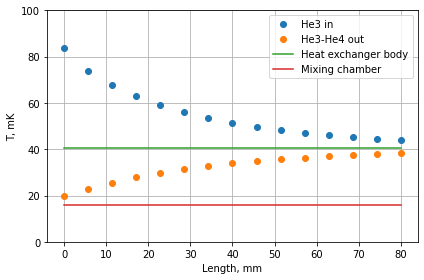

In [113]:
ym=1e3
xm = 1e3
x = linspace(0,Lhex*xm, N)
plot(x,sol[:N]*ym, 'o', label = "He3 in")
plot(x,sol[N:2*N]*ym, 'o', label = "He3-He4 out")
plot( x,ones(N)*sol[-2]*ym, label = "Heat exchanger body")
plot( x,ones(N)*sol[-1]*ym, label = "Mixing chamber")
ylabel("T, mK")
xlabel("Length, mm")
ylim([0,100])
legend()
grid()
tight_layout()
savefig("single_stage_hex.png", dpi = 300)

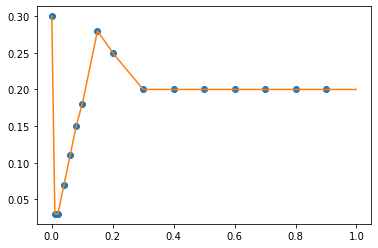

In [45]:
plot(data[::,0], data[::,1],'o')
x = arange(0, 1, 0.001)
plot(x, heat_cond_d(x))
